<a href="https://colab.research.google.com/github/Kevindx98/FSI-CNN-FacialAge/blob/master/Facial_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de Edad Facial

Se va a tratar de estudiar una **Red Neuronal Convolutiva**  que sea capaz de reconocer la Edad Facial de una persona dada su foto. 

## Requisitos
- Dicha foto, para que funcione dicha CNN deberá ser lo más parecida a una foto de Carnet.
- Nuestra CNN podrá reconocer, en principio, 6 intervalos de edad cerrados (Los relatados según [*minsalud*](https://www.minsalud.gov.co/proteccionsocial/Paginas/cicloVida.aspx) ), entre los que se incluyen:
```java
1) Primera Infancia (1-5 años)
2) Infancia (6-12 años)
3) Adolescencia (13-18 años)
4) Juventud (19-25 años)
5) Adultez (26-60 años)
6) Persona Mayor (+60 años)
```
- Evidentemente el DataSet usado debe estar en el directorio al cual nuestro código va a apuntar para formar el Modelo. En mi caso, utilizaré Google Drive para almacenarlo.

## Notas
- El DataSet se ha obtenido de 'Kaggle'. Tiene como nombre ''*face-age*''.
- El DataSet fue modificado de dos formas. La primera de ellas, para formar los rangos de edad antes expuestos (El dataset original dividía las edades individualmente y nosotros queremos que ésto sea por rango). La segunda forma fue para quitar aquellas fotos que no cumplían los requisitos mencionados previamente (Foto borrosa, inadecuada, con marca de agua...)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Comprobación de que el DataSet se ha importado correctamente:

1  2  3  4  5  6


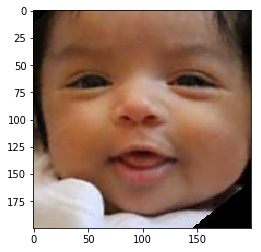

In [3]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/facial_age"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png', 'r')
imshow(np.asarray(pil_im))

### Comprobación de la GPU utilizada:

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

 ## Primera Idea de Modelo: 
 
 Para la primera versión de nuestra CNN:
 - Los datos de Entrenamiento tendrán un reescalado en sus píxeles a un valor [0-1]. Además, sufrirán un rotado y un zoom.
 - Se generarán dos tipos de datos: *Train* y *Validation*. Uno servirá para entrenar nuestra CNN y el otro para que, a raíz de los entrenamientos de cada Epoch, se trate de mejorar el *accuracy* reduciendo *Overfitting*. Se debe tener en cuenta que las fotos tienen unas dimensiones de 200x200. (Se redimensionarán a 100x100)
 - El modelo tendrá como primeras capas las convolucionales. A continuación, se usarán técnicas para reducir los datos y quedarnos con los más importantes como *MaxPooling* y otras para reducir el Overfitting como *Dropout*. El modelo, por último, aplanará los datos de entrada y se pasarán los datos por una serie de capas densas básicas.
 - Se utilizará *Categorical_Crossentropy* como *loss* y *RMSProp* como *optimizador*.
 - En un principio, se tendrán 10 Epochs, con una serie de *steps_per_epoch* y de *validation_steps* arbitrarios.

### Imports

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import time
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Data Source

In [35]:
data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(100, 100),
        batch_size=128,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 4274 images belonging to 6 classes.
Found 472 images belonging to 6 classes.


### Model

In [36]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 10, 128)       0         
__________

### Training

In [37]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//20,
        epochs=10, 
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//32,
)

Epoch 1/10
213/213 [==============================] - 136s 638ms/step - loss: 1.4754 - acc: 0.4080 - val_loss: 1.1024 - val_acc: 0.5290
Epoch 2/10
213/213 [==============================] - 135s 635ms/step - loss: 0.9893 - acc: 0.6027 - val_loss: 1.0325 - val_acc: 0.5977
Epoch 3/10
213/213 [==============================] - 133s 626ms/step - loss: 0.7436 - acc: 0.7025 - val_loss: 0.9959 - val_acc: 0.6341
Epoch 4/10
213/213 [==============================] - 134s 629ms/step - loss: 0.5698 - acc: 0.7737 - val_loss: 1.0034 - val_acc: 0.6318
Epoch 5/10
213/213 [==============================] - 137s 644ms/step - loss: 0.4379 - acc: 0.8271 - val_loss: 1.2395 - val_acc: 0.6682
Epoch 6/10
213/213 [==============================] - 133s 623ms/step - loss: 0.3331 - acc: 0.8773 - val_loss: 1.1077 - val_acc: 0.6864
Epoch 7/10
213/213 [==============================] - 136s 639ms/step - loss: 0.2661 - acc: 0.9013 - val_loss: 1.3537 - val_acc: 0.6523
Epoch 8/10
213/213 [============================

#### También podemos cargar un modelo compilado:

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/models/facialage_model.h5')

### Test

In [38]:
# y_testReal = [5,15,25,35,45,55,65,75,85]
y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,3,4,5,5,5,6,6,6]
X_test = np.empty((9,100,100,3))
X_test[0] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[1] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/3/49.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[2] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/4/51.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[3] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5350.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[4] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5394.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[5] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5565.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[6] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1265.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[7] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1618.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[8] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/3412.png')).resize((100,100))).reshape(1,100,100,3)/255)

predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])


[1.0000000e+00 1.9475482e-10 4.8465885e-20 1.3515086e-27 2.3691116e-29
 6.6656553e-31] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[3.4932323e-06 1.2569678e-04 9.9966812e-01 1.1965873e-04 8.3099199e-05
 8.0338858e-10] -> 3
Predicción:  13-18  |||  Valor Real:  13-18
[3.5755642e-07 9.1089540e-05 3.1862077e-03 9.9562693e-01 1.0954957e-03
 1.8095958e-12] -> 4
Predicción:  19-25  |||  Valor Real:  19-25
[7.73494657e-10 1.05612635e-07 9.21967498e-04 3.34779383e-04
 9.98742163e-01 9.52569167e-07] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[2.47885995e-13 1.19471615e-08 3.14083479e-07 7.62949185e-06
 9.99964714e-01 2.73448386e-05] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[1.6012438e-15 2.8713117e-15 1.1339669e-08 1.0909359e-03 9.9525189e-01
 3.6571389e-03] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[5.3014208e-15 2.6150662e-10 9.1010544e-10 9.4531361e-10 1.6566442e-01
 8.3433563e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60
[1.8523531e-19 6.5612300e-11 2.1836116e-13 3

[9.9986529e-01 1.3464362e-04 8.2095587e-16 4.0270133e-19 5.4596763e-24
 6.7159747e-25] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[4.7276583e-09 1.6211470e-05 5.4689139e-05 3.7594073e-02 9.6225965e-01
 7.5363845e-05] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[9.8726194e-10 7.4085773e-07 1.0762507e-10 4.4684173e-15 4.8080956e-06
 9.9999452e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60


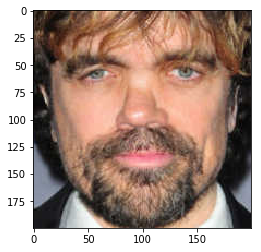

In [39]:
%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg', 'r')
imshow(np.asarray(pil_im))

y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,5,6]
X_test = np.empty((3,100,100,3))
X_test[0] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/bebe.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[1] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[2] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/papa.png')).resize((100,100))).reshape(1,100,100,3)/255
predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

### Visualizamos cómo el Modelo ha ido adquiriendo *accuracy* y perdiendo *loss*.

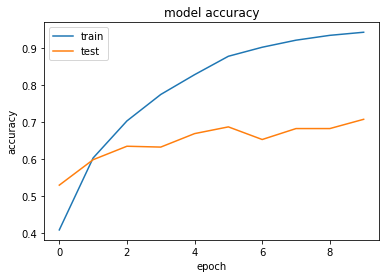

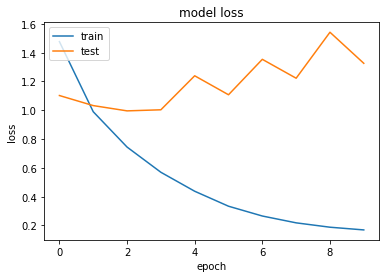

In [40]:
#accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Guardamos el Modelo:

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/facialage_model.h5')

## Segunda Idea de Modelo (Usando Keras VGG-16)

Hasta ahora hemos creado un modelo desde su inicio. Pero... ¿Y si partiéramos de una ***Red Neuronal existente*** y le añadiéramos las capas densas apropiadas para nuestro caso?

Se va a tratar de usar la Red Neuronal VGG-16:

### Imports
Repetimos algunos **imports** en caso de no haber ejecutado nada del Primer Modelo.

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from time import time
import numpy as np
import matplotlib.pyplot as plt

### Data Source
Repetimos la carga de datos en caso de no haber ejecutado nada del Primer Modelo.

In [45]:
data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/facial_age'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(100, 100),
        batch_size=64,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 4274 images belonging to 6 classes.
Found 472 images belonging to 6 classes.


### Model
#### Usamos Keras VGG-16

In [46]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))
for layer in model_vgg16.layers[2:9]:
    layer.trainable = False
    
for layer in model_vgg16.layers[11:]:
    layer.trainable = False

58892288/58889256 [==============================] - 3s 0us/step


#### Añadimos nuestras capas densas personalizadas después de las capas convolutivas de VGG-16:

In [47]:
x = Flatten()(model_vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(6, activation='softmax')(x)

model = Model(input=model_vgg16.input, output=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


### Training

In [48]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//20,
        epochs=25, 
        validation_data=validation_generator,
        validation_steps=train_generator.samples//32,
)

Epoch 1/25
213/213 [==============================] - 100s 470ms/step - loss: 1.6740 - acc: 0.3269 - val_loss: 1.2245 - val_acc: 0.5155
Epoch 2/25
213/213 [==============================] - 95s 447ms/step - loss: 1.1547 - acc: 0.5265 - val_loss: 1.4989 - val_acc: 0.4450
Epoch 3/25
213/213 [==============================] - 93s 436ms/step - loss: 0.9740 - acc: 0.5971 - val_loss: 0.9684 - val_acc: 0.5944
Epoch 4/25
213/213 [==============================] - 93s 435ms/step - loss: 0.8625 - acc: 0.6418 - val_loss: 1.0459 - val_acc: 0.6016
Epoch 5/25
213/213 [==============================] - 95s 444ms/step - loss: 0.7830 - acc: 0.6718 - val_loss: 0.8755 - val_acc: 0.6479
Epoch 6/25
213/213 [==============================] - 94s 442ms/step - loss: 0.7190 - acc: 0.7058 - val_loss: 0.9096 - val_acc: 0.6346
Epoch 7/25
213/213 [==============================] - 94s 441ms/step - loss: 0.6725 - acc: 0.7221 - val_loss: 0.9066 - val_acc: 0.6558
Epoch 8/25
213/213 [==============================] - 

#### Cargamos el Modelo:

In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/models/facialage_model_vgg16.h5')

### Test

In [49]:
# y_testReal = [5,15,25,35,45,55,65,75,85]
y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,3,4,5,5,5,6,6,6]
X_test = np.empty((9,100,100,3))
X_test[0] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/1/4882.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[1] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/3/49.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[2] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/4/51.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[3] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5350.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[4] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5394.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[5] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/5/5565.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[6] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1265.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[7] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/1618.png')).resize((100,100))).reshape(1,100,100,3)/255)
X_test[8] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/facial_age/6/3412.png')).resize((100,100))).reshape(1,100,100,3)/255)

predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

[1.0000000e+00 2.1020928e-11 4.2946759e-27 7.1296720e-20 4.3421333e-28
 6.4047723e-24] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[3.5195956e-13 6.6145073e-04 9.9902821e-01 2.6775899e-04 4.2662079e-05
 1.5783599e-09] -> 3
Predicción:  13-18  |||  Valor Real:  13-18
[3.8327847e-15 3.4784321e-08 1.0528193e-02 9.8858905e-01 8.8283181e-04
 7.9890755e-12] -> 4
Predicción:  19-25  |||  Valor Real:  19-25
[7.0172938e-21 1.9414381e-14 4.9801524e-11 6.7241468e-05 9.9992871e-01
 4.1064604e-06] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[2.1499882e-15 1.6849449e-09 2.1541613e-05 4.0379008e-03 9.8718286e-01
 8.7577235e-03] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[4.7591204e-25 6.6715111e-18 1.2683151e-12 5.4700748e-05 9.9977285e-01
 1.7245831e-04] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[1.0442945e-32 1.4605805e-22 6.8988434e-24 1.2567245e-21 1.7795905e-08
 1.0000000e+00] -> 6
Predicción:  +60  |||  Valor Real:  +60
[1.1368240e-23 3.0381268e-21 1.1317306e-24 5.2811274e-21

[1.0000000e+00 5.0479663e-20 0.0000000e+00 1.1706346e-32 3.4762738e-36
 6.4113400e-34] -> 1
Predicción:  1-5  |||  Valor Real:  1-5
[4.6048507e-27 1.5687795e-11 1.6470694e-05 3.3275667e-04 9.9965060e-01
 1.1915314e-07] -> 5
Predicción:  26-60  |||  Valor Real:  26-60
[1.3095553e-14 9.4340480e-11 1.2041344e-13 3.7351862e-12 9.2028895e-05
 9.9990797e-01] -> 6
Predicción:  +60  |||  Valor Real:  +60


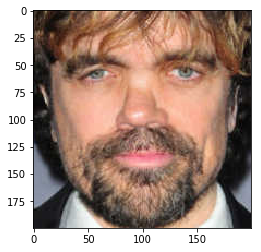

In [50]:
%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg', 'r')
imshow(np.asarray(pil_im))

y_testRes =['1-5', '6-12', '13-18', '19-25', '26-60', '+60']
y_test = [1,5,6]
X_test = np.empty((3,100,100,3))
X_test[0] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/bebe.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[1] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/tyrion.jpg')).resize((100,100))).reshape(1,100,100,3)/255
X_test[2] = np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/prueba/papa.png')).resize((100,100))).reshape(1,100,100,3)/255
predictions = model.predict(X_test)
for p,l in zip(predictions, y_test):
  print(p, "->", l)
  result = np.where(p == np.amax(p))[0]
  print("Predicción: ", y_testRes[int(result)], " ||| ", "Valor Real: ", y_testRes[l-1])

### Visualizamos cómo el Modelo ha ido adquiriendo *accuracy* y perdiendo *loss*.

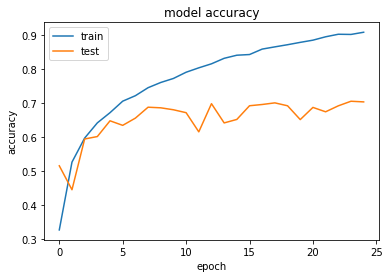

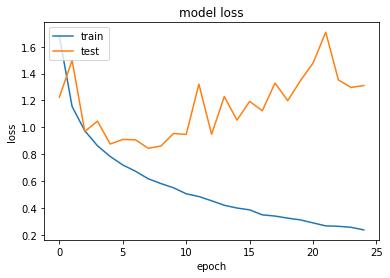

In [51]:
#accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Guardamos el Modelo:

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/facialage_model_vgg16.h5')